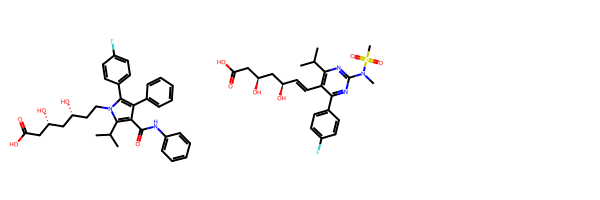

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit

%load_ext autoreload
%autoreload 2


atorvastatin = Chem.MolFromSmiles('O=C(O)C[C@H](O)C[C@H](O)CCn2c(c(c(c2c1ccc(F)cc1)c3ccccc3)C(=O)Nc4ccccc4)C(C)C')
rosuvastatin = Chem.MolFromSmiles('OC(=O)C[C@H](O)C[C@H](O)\C=C\c1c(C(C)C)nc(N(C)S(=O)(=O)C)nc1c2ccc(F)cc2')
Draw.MolsToGridImage((atorvastatin,rosuvastatin))

In [34]:
seta = {1,2,3}
dic = {1:10, 2:20, 5:50}

seta.intersection(dic)

{1, 2}

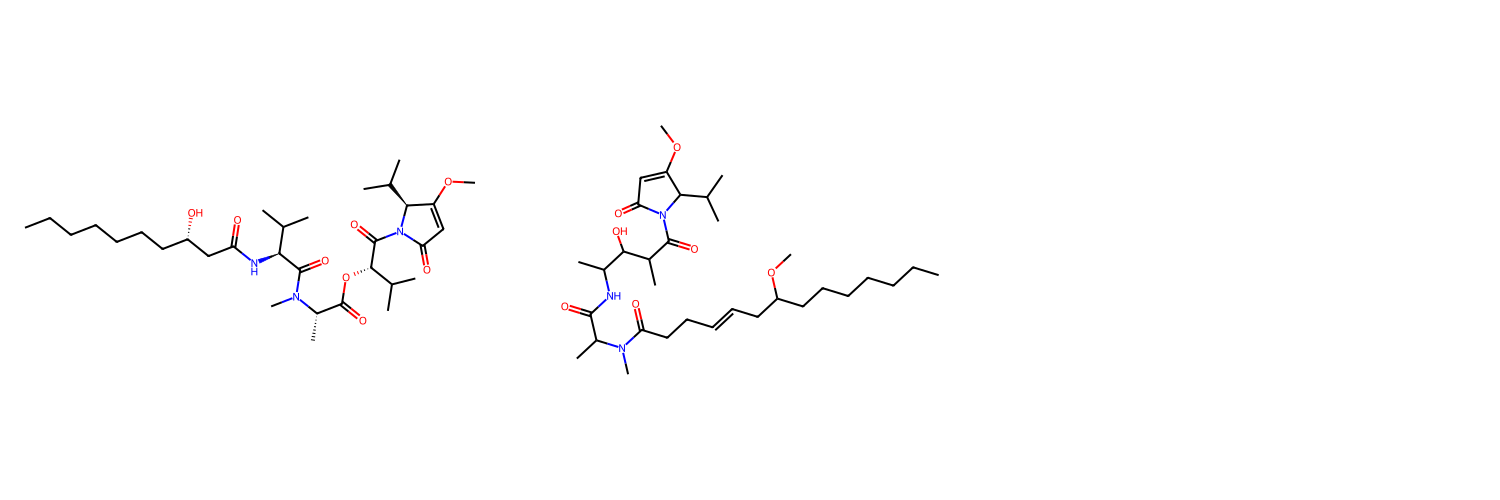

In [2]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A = Chem.MolFromSmiles(Kavaratamide_A_SMILES)

s1_SMILES = "CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC"
s1 = Chem.MolFromSmiles(s1_SMILES)

Draw.MolsToGridImage((Kavaratamide_A,s1), subImgSize=(500,500))

In [3]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img
d = Draw.MolDraw2DCairo(400, 400)


[19:07:53] DEPRECATION WARNING: please use MorganGenerator
[19:07:53] DEPRECATION WARNING: please use MorganGenerator


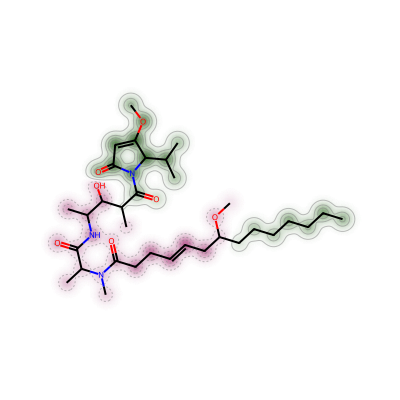

In [24]:
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(Kavaratamide_A, s1, 
                                        lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=8, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

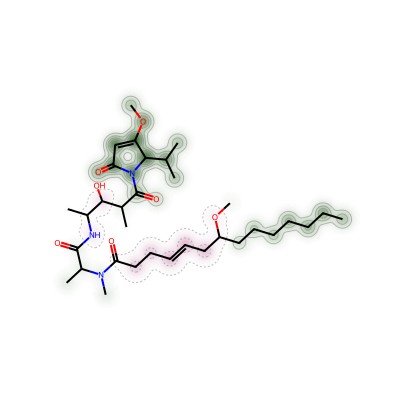

In [5]:
weights = [0.050793650793650835, 0.07218045112781957, 0.061407249466950975, 0.061407249466950975, 0.046481876332622574, 0.04210526315789476, 0.02857142857142858, -0.007087486157253631, -0.03296703296703296, -0.03809523809523807, -0.03809523809523807, -0.027917121046892035, -0.027917121046892035, -0.00219780219780219, 0.0017057569296374808, 0.01318681318681314, 0.016631130063965882, 0.01318681318681314, 0.016631130063965882, 0.01318681318681314, 0.0017057569296374808, -0.012649945474372926, -0.00219780219780219, 0.0017057569296374808, -0.01758241758241763, 0.0017057569296374808, 0.01318681318681314, 0.0017057569296374808, 0.05492801771871536, 0.03155650319829428, 0.10888638920134985, 0.10143964562569208, 0.061407249466950975, 0.10549450549450545, 0.12857142857142856, 0.08311688311688314, 0.050793650793650835, 0.12463442069741282, 0.08311688311688314, 0.050793650793650835, 0.050793650793650835, -0.007792207792207795, 0.006349206349206327]

SimilarityMaps.GetSimilarityMapFromWeights(s1,weights,draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

In [7]:
from rdkit.Chem import rdFingerprintGenerator

gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
FP_kav = np.array(gen.GetFingerprint(mol=Kavaratamide_A))
FP_s1 = np.array(gen.GetFingerprint(mol=s1))
FP_single_atom_8 = np.array(gen.GetFingerprint(mol=s1, fromAtoms=[8]))

In [8]:
from rdkit import Chem, DataStructs, Geometry

def cosine_similarity(fp1, fp2):
    """
    Calculate the cosine similarity between two numpy arrays.
    """
    fp1 = fp1.astype(np.float32)
    fp2 = fp2.astype(np.float32)
    dot_product = np.dot(fp1, fp2)
    norm_a = np.linalg.norm(fp1)
    norm_b = np.linalg.norm(fp2)
    return dot_product / (norm_a * norm_b)

In [9]:
cosine_similarity(FP_kav, FP_s1), cosine_similarity(FP_kav, FP_single_atom_8), cosine_similarity(FP_s1, FP_single_atom_8)

(np.float32(0.62914956), np.float32(0.07053457), np.float32(0.20272122))

[18:53:00] DEPRECATION WARNING: please use MorganGenerator
[18:53:00] DEPRECATION WARNING: please use MorganGenerator


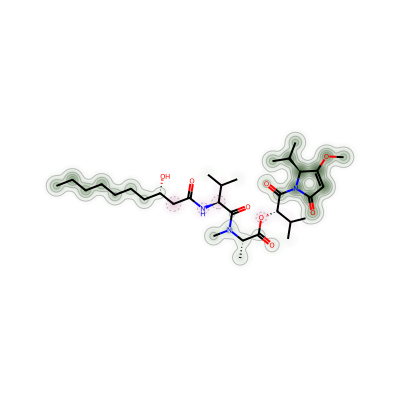

In [10]:
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(s1, Kavaratamide_A,
                                        lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import fp_loader_configer
import numpy as np

fp_loader_configer.select_version("DB_Specific")
fp_loader = fp_loader_configer.fp_loader





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


choosing DB_Specific_FP_loader


In [25]:
fp_loader.setup(16384*2, 8)


finish entropy list
DB_Specific_FP_loader is setup


(array([-2.52970945e-01, -5.16489599e-02, -2.52812635e-01, ...,
        -2.77973237e-06, -2.77973237e-06, -2.77973237e-06]),
 array([526315,  60104, 525798, ...,      1,      1,      1]),
 8266572)

In [26]:
Kavaratamide_A_FP = fp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)
# ideally, this is predicted by the model
predicted_FP = Kavaratamide_A_FP

In [27]:
predicted_FP.dtype

torch.float32

In [ ]:
#This is a binary cosine between two sets
from math import sqrt

def set_based_cosine(x,y):
    '''x, y are same shape array'''
    a = set(x)
    b = set(y)
    return (len(a&b))/(sqrt(len(a))*sqrt(len(b)))

In [29]:
from notebook_and_scripts.SMILES_fragmenting.build_dataset_specific_FP.find_frags import get_fragments_for_each_atom_id, get_fragments_for_each_atom_id_v2

# get_fragments_with_its_atom_ids("CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC")

In [30]:
fp_loader_frags = set(fp_loader.frag_to_index_map.keys())


In [31]:
fp_loader.construct_index_to_frag_mapping()

In [ ]:
def show_similarity_map(predicted_FP, retrieval_smiles, show_H=False):
    predicted_frag_indices = set(predicted_FP.nonzero()[:,0].tolist())
    retrieval_FP = fp_loader.build_mfp_for_new_SMILES(retrieval_smiles)
    
    # Step 1: Create molecule and hydrogenated copy
    retrieval_mol_h = Chem.MolFromSmiles(retrieval_smiles)
    retrieval_mol_h = Chem.AddHs(retrieval_mol_h)  # Keep explicit Hs for fragment mapping
    
    weights_h = [0] * retrieval_mol_h.GetNumAtoms()
    base_sim = set_based_cosine(predicted_frag_indices, retrieval_FP.nonzero()[:,0].tolist())
    # Step 2: Compute weights on the molecule WITH hydrogens
    atom_to_frags, all_frags  = get_fragments_for_each_atom_id_v2(retrieval_smiles)
    for atom_id, frags in atom_to_frags.items():
        frag_indices_with_this_atom = {fp_loader.frag_to_index_map[frag] for frag in (all_frags-frags).intersection(fp_loader_frags) }
        sim_without_this_atom = set_based_cosine(frag_indices_with_this_atom, predicted_frag_indices)
        
        # sim_without_this_atom = set_based_cosine((all_frags-frags).intersection(fp_loader_frags), {fp_loader.index_to_frag_mapping[i] for i in predicted_frag_indices})
        weights_h[atom_id] = base_sim - sim_without_this_atom

    weights_h, max_weight = SimilarityMaps.GetStandardizedWeights(weights_h)
    
    if not show_H:
        # Step 3: Remove explicit hydrogens and map weights
        retrieval_mol = Chem.RemoveHs(retrieval_mol_h)
        
        # Step 4: Map hydrogenated weights to non-hydrogenated molecule
        heavy_atom_map = retrieval_mol_h.GetSubstructMatch(retrieval_mol)  # Maps H-heavy to no-H
        
        weights = [weights_h[i] for i in heavy_atom_map]  # Remap weights to no-H molecule

    # Step 5: Draw similarity map on molecule without hydrogens
    d = Draw.MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapFromWeights(retrieval_mol, weights, draw2d=d)
    
    d.FinishDrawing()
    display(show_png(d.GetDrawingText()))

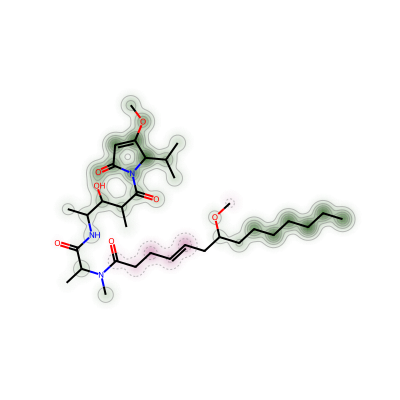

In [33]:
show_similarity_map(predicted_FP, "CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC")